# Cross-validation of models for Gouwens et al.

In [1]:
# Import packages
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib
import seaborn as sns
import sparseRRR
import matplotlib
import matplotlib.pyplot as plt
import importlib

import bottleneck_networks_tf2

import time
import pickle
import warnings

dtype = tf.float32

def sns_styleset():
    sns.set_style('ticks', {'axes.linewidth': .75, "xtick.major.size":4, "ytick.major.size":4})

# Loading data

In [2]:
gouwens = pickle.load(open('data/gouwens_2020/gouwens2020.pickle', 'rb'))
genes=gouwens['X']
ephys=gouwens['Y']
gene_names=gouwens['gene_names']
cell_types=gouwens['celltypes']
cell_id_to_cell_type=gouwens['map']
ephys_names=gouwens['ephys_features']
colors=gouwens['colors']

Let us find K-mean clusters to perform pre-training. One could also pre-train on celltype classification. This has actually improved performance even more but could be argued to be biasing the results too much. K-means allows for an unsupervised more general setting.

In [3]:
# You can cluster according to amounts of classes or amounts of celltypes. Change the argument of n_clusters accordingly.
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=20, random_state=17, n_init=1000).fit(ephys)

In [4]:
clusters = kmeans.labels_

In [5]:
amount_of_cells_in_clusters = {cluster_id: sum(clusters==cluster_id) for cluster_id in np.unique(clusters)}
for_every_cell_number_of_cells_of_their_cluster = np.array([amount_of_cells_in_clusters[cell] for cell in clusters])
ind_pre_training_clusters = for_every_cell_number_of_cells_of_their_cluster >= 10

In [6]:
c_n=[]
for i in np.unique(clusters):
    print('cluster', i, 'represented by', sum(clusters==i), 'cells.')
    c_n.append(sum(clusters==i))
print('average # of cells per cluster:', np.mean(np.array(c_n)))
print('std of # of cells per cluster:', np.std(np.array(c_n)))

cluster 0 represented by 119 cells.
cluster 1 represented by 77 cells.
cluster 2 represented by 166 cells.
cluster 3 represented by 253 cells.
cluster 4 represented by 220 cells.
cluster 5 represented by 169 cells.
cluster 6 represented by 136 cells.
cluster 7 represented by 77 cells.
cluster 8 represented by 79 cells.
cluster 9 represented by 195 cells.
cluster 10 represented by 165 cells.
cluster 11 represented by 112 cells.
cluster 12 represented by 195 cells.
cluster 13 represented by 234 cells.
cluster 14 represented by 179 cells.
cluster 15 represented by 285 cells.
cluster 16 represented by 198 cells.
cluster 17 represented by 284 cells.
cluster 18 represented by 135 cells.
cluster 19 represented by 117 cells.
average # of cells per cluster: 169.75
std of # of cells per cluster: 62.68801719627125


# Keras initialisations

In [7]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import metrics
from tensorflow.keras.losses import CategoricalCrossentropy

In [8]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K

In [9]:
tf.compat.v1.disable_eager_execution()

In [10]:
# You should assume you get two TensorFlow variables as input
y_actual = tf.compat.v1.placeholder(dtype = tf.float32)
y_predicted = tf.compat.v1.placeholder(dtype = tf.float32)
def r2_score(y_truth, y_pred):
    residual = tf.add(y_truth, -y_pred, name='residual')
    return 1-tf.reduce_sum(input_tensor=tf.square(residual)) / tf.reduce_sum(input_tensor=tf.square(y_truth))
r2_score_result = r2_score(y_actual, y_predicted)

In [11]:
class ElasticNet(tf.keras.regularizers.Regularizer): 
    def __init__(self, l1=1e-8, l2=1.0): 
        self.l1 = l1
        self.l2 = l2

    def __call__(self, x): 
        return self.l2*tf.math.reduce_sum(input_tensor=tf.math.square(x)) + \
                             self.l1*tf.reduce_sum(input_tensor=tf.norm(tensor=x, ord = 2, axis = 1))

    def get_config(self): 
        return {'l1': float(self.l1), 'l2': float(self.l2)}

## Cross validation to various training strategies

It seems that pre-train - train 4 last layers - train all layers is a good bottleneck non-linear model. By adding a lasso group penalty we can investigate which genes the model would select. After the usual training as above we also prune the bottleneck further. In essence we pick the 25 genes that correspond to highest L2 row norm for the first kernel/weight of the input layer and perform the same regression task but with this reduced new 25 nodes input layer. No lasso, just ridge for this pruned network. We investigate which genes are selected, visualise the latent space and compare to a well-known sparse reduced-rank model for this dataset. Again, one can skip the training and go direct to visualization for already trained models.

Group lasso + ridge penalty straight regression (no pre-training) model.

In [13]:
from bottleneck_networks_tf2 import StraightRegression

In [14]:
# Settings
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-1])

act = 'elu'
folds = 10
seed = 42
lr=0.0001
epochs=50
bs=32
prune=True
patience=epochs

r2_straight_regr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_straight_regr_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_straight_regr_ap = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_straight_regr_ap_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_straight_regr_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))
r2_straight_regr_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))

t = time.time()
np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]

nodes_list=[512,128,2,128,512]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    input_dim = x_train.shape[1]
    output_dim = y_train.shape[1]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)
            BN_StraightRegression = StraightRegression(l1=l1, l2=l2, lr=lr, act=act, \
                                                       input_dim=input_dim, output_dim=output_dim, nodes_list=nodes_list)
            r2_train, r2_test, \
                r2_ap_train, r2_ap_test, \
                train_hist, test_hist = BN_StraightRegression.train(x_train=x_train, y_train=y_train, \
                                                                                   x_test=x_test, y_test=y_test, \
                                                                                   epochs=epochs, bs=bs, patience=patience, \
                                                                                   cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                                   prune=prune, geneNames=gene_names, \
                                                                                   verbose=0)
            r2_straight_regr[cvfold, j, i] = r2_test
            r2_straight_regr_tr[cvfold, j, i] = r2_train
            r2_straight_regr_ap[cvfold, j, i] = r2_ap_test
            r2_straight_regr_ap_tr[cvfold, j, i] = r2_ap_train
            r2_straight_regr_hist[cvfold, j, i] = test_hist
            r2_straight_regr_hist_tr[cvfold, j, i] = train_hist
            #print('Test R^2 score (straight regression, no pre-tr): ', r2_straight_regr[cvfold, j, i])
            #print('Test R^2 score after pruning (straight regression, no pre-tr): ', r2_straight_regr_ap[cvfold, j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[INFO] training network...


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


The 25 genes that make it:  ['Cacna1e' 'March1' 'Cdh12' 'Sema3a' 'Gabrb2' 'Kcns3' 'Kctd8' 'Cplx3'
 'Igf1' 'Pou3f3' 'Crtac1' 'Grm1' 'Kcnc2' 'Nell1' 'Cacna2d3' 'Runx2'
 'Pde11a' 'Kit' 'Pvalb' 'Alcam' 'Trhde' 'Lamp5' 'Vip' 'Fxyd6' 'Synpr']
[INFO] training network...
Train R^2 before pruning:  0.25683659315109253
Test R^2 after pruning:  0.2716056704521179
Train R^2 after pruning:  0.2625267505645752
Test R^2 after pruning:  0.2720639109611511

CVFOLD:  1
[INFO] training network...
The 25 genes that make it:  ['Kcnd3' 'Sox5' 'Pcp4l1' 'Grm7' 'Kctd8' 'Alcam' 'Ptchd2' 'Gpr126' 'Man1a'
 'Chodl' 'Runx2' 'Akr1c18' 'Gabrd' 'Pde11a' 'Trhde' 'Grm1' 'Lamp5' 'Igf1'
 'Cplx3' 'Kcnc2' 'Vip' 'Pvalb' 'Cacna2d3' 'Fxyd6' 'Synpr']
[INFO] training network...
Train R^2 before pruning:  0.2558351159095764
Test R^2 after pruning:  0.2537192702293396
Train R^2 after pruning:  0.25790631771087646
Test R^2 after pruning:  0.2528805732727051

CVFOLD:  2
[INFO] training network...
The 25 genes that make it:  ['Crtac1

In [15]:
with open('KerasSavedModels/gouwens_2020_tf2/Bottleneck_r2_straight_regr_lasso.pickle', 'wb') as f:
    pickle.dump([r2_straight_regr, r2_straight_regr_tr, \
                 r2_straight_regr_ap, r2_straight_regr_ap_tr, \
                 r2_straight_regr_hist, r2_straight_regr_hist_tr], f)

Group lasso + ridge penalty classification pre-training model.

In [16]:
from bottleneck_networks_tf2 import ClassificationPreTrain

In [17]:
# Immediately for different penalties, but we'll be only interested in the 1e-1 penalty (for now), i.e. see extensions later
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-4, 1e-2, 1e-1, 1])

act = 'elu'
folds = 10
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs


t = time.time()
np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]
clusters_ = clusters[ind]
ind_pre_train = ind_pre_training_clusters[ind]

CE_loss = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
CE_loss_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
pre_tr_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], epochs))
pre_tr_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], epochs))

nodes_list=[512,128,2,128,512]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    clusters_train = np.copy(clusters_[indtrain])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    clusters_test = np.copy(clusters_[indtest])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean

    # In our training set we now look for a 'pretraining' training and test data set that we can use
    # for pretraing a classification network, i.e. picking the best model will be dones with a seperate val set in our
    # training set for regression.

    x_train_pre_tr = x_train[ind_pre_train[indtrain], :]
    clusters_train_pre_tr = clusters_train[ind_pre_train[indtrain]]
    
    pre_train_size = 0.6
    train_cnt = round(x_train_pre_tr.shape[0]*pre_train_size)
    x_train_pre_tr_ = x_train_pre_tr[:train_cnt, :]
    x_test_pre_tr_ = x_train_pre_tr[train_cnt:, :]
    clusters_train_pre_tr_ = clusters_train_pre_tr[:train_cnt]
    clusters_test_pre_tr_ = clusters_train_pre_tr[train_cnt:]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)


            input_dim = x_train.shape[1]
            output_dim = to_categorical(clusters_train_pre_tr).shape[1]
            BN_Classification = ClassificationPreTrain(l1=l1, l2=l2, lr=lr, act=act, input_dim=input_dim, \
                                                       output_dim=output_dim, nodes_list=nodes_list)
            CE_train, CE_test, train_hist, test_hist = BN_Classification.train(x_train=x_train_pre_tr_, \
                                                                               cluster_train=clusters_train_pre_tr_, \
                                                                               x_test=x_test_pre_tr_, \
                                                                               cluster_test=clusters_test_pre_tr_, \
                                                                               epochs=epochs, bs=bs, patience=patience, \
                                                                               cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                               verbose=0)
            CE_loss[cvfold, j, i] = CE_test
            CE_loss_tr[cvfold, j, i] = CE_train
            pre_tr_hist[cvfold, j, i] = test_hist
            pre_tr_hist_tr[cvfold, j, i] = train_hist
            #print('Test CE loss (pre-trainin): ', CE_loss[cvfold, j, i])
            
t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0
[INFO] training network...
[INFO] training network...
[INFO] training network...
[INFO] training network...

CVFOLD:  1
[INFO] training network...
[INFO] training network...
[INFO] training network...
[INFO] training network...

CVFOLD:  2
[INFO] training network...
[INFO] training network...
[INFO] training network...
[INFO] training network...

CVFOLD:  3
[INFO] training network...
[INFO] training network...
[INFO] training network...
[INFO] training network...

CVFOLD:  4
[INFO] training network...
[INFO] training network...
[INFO] training network...
[INFO] training network...

CVFOLD:  5
[INFO] training network...
[INFO] training network...
[INFO] training network...
[INFO] training network...

CVFOLD:  6
[INFO] training network...
[INFO] training network...
[INFO] training network...
[INFO] training network...

CVFOLD:  7
[INFO] training network...
[INFO] training network...
[INFO] training network...
[INFO] training network...

CVFOLD:  8
[INFO] training network...
[

In [18]:
with open('KerasSavedModels/gouwens_2020_tf2/Bottleneck_pre_tr_lasso.pickle', 'wb') as f:
    pickle.dump([CE_loss, CE_loss_tr, pre_tr_hist, pre_tr_hist_tr], f)

Group lasso + ridge penalty pre-train and regression model.

In [19]:
# Settings
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-1])

act = 'elu'
folds = 10
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs
pre_trained_weights=True
prune=True

r2_pretr_straight_regr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_pretr_straight_regr_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_pretr_straight_regr_ap = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_pretr_straight_regr_ap_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_pretr_straight_regr_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))
r2_pretr_straight_regr_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))

t = time.time()
np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]

nodes_list=[512,128,2,128,512]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    input_dim = x_train.shape[1]
    output_dim = y_train.shape[1]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)
            
            pre_trained_weights_h5 = 'KerasSavedModels/Classification_last_weights_{}_{}_{}.h5'.format(cvfold, 2, i)
            
            BN_PreTrStraightRegression = StraightRegression(l1=l1, l2=l2, lr=lr, act=act, \
                                            input_dim=input_dim, output_dim=output_dim, \
                                            pre_trained_weights=pre_trained_weights, \
                                            pre_trained_weights_h5=pre_trained_weights_h5, nodes_list=nodes_list)
            r2_train, r2_test, \
                r2_train_ap, r2_test_ap, \
                train_hist, test_hist = BN_PreTrStraightRegression.train(x_train=x_train, y_train=y_train, \
                                                                                   x_test=x_test, y_test=y_test, \
                                                                                   epochs=epochs, bs=bs, patience=patience, \
                                                                                   cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                                   prune=prune, geneNames=gene_names, \
                                                                                   verbose=0)
            r2_pretr_straight_regr[cvfold, j, i] = r2_test
            r2_pretr_straight_regr_tr[cvfold, j, i] = r2_train
            r2_pretr_straight_regr_ap[cvfold, j, i] = r2_test_ap
            r2_pretr_straight_regr_ap_tr[cvfold, j, i] = r2_train_ap            
            r2_pretr_straight_regr_hist[cvfold, j, i] = test_hist
            r2_pretr_straight_regr_hist_tr[cvfold, j, i] = train_hist
            #print('Test R^2 score (regression, after pre-tr): ', r2_pretr_straight_regr[cvfold, j, i])
            #print('Test R^2 score (regression, after pre-tr), after pruning: ', r2_pretr_straight_regr_ap[cvfold, j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0
[INFO] training network...
The 25 genes that make it:  ['Cacna1e' 'Grm1' 'Cdh12' 'Gabrb2' 'Kcns3' 'Grm7' 'Ptchd2' 'Pou3f3'
 'Cacna2d3' 'Crtac1' 'Cplx3' 'Runx2' 'Pde11a' 'March1' 'Nell1' 'Pvalb'
 'Alcam' 'Sema3a' 'Kcnc2' 'Lamp5' 'Kit' 'Trhde' 'Vip' 'Fxyd6' 'Synpr']
[INFO] training network...
Train R^2 before pruning:  0.26360398530960083
Test R^2 after pruning:  0.2803691029548645
Train R^2 after pruning:  0.26468896865844727
Test R^2 after pruning:  0.2766885757446289

CVFOLD:  1
[INFO] training network...
The 25 genes that make it:  ['Kcnab3' 'Pcp4l1' 'Trhde' 'Cpne7' 'Cplx3' 'Kcnd3' 'Man1a' 'Runx2' 'Grm1'
 'Gabrd' 'Lamp5' 'Hpse' 'Igf1' 'Egfem1' 'Col11a1' 'Akr1c18' 'Kcnc2' 'Penk'
 'Ptpru' 'Pdyn' 'Pvalb' 'Cacna2d3' 'Vip' 'Fxyd6' 'Synpr']
[INFO] training network...
Train R^2 before pruning:  0.2626572847366333
Test R^2 after pruning:  0.2582915425300598
Train R^2 after pruning:  0.26223379373550415
Test R^2 after pruning:  0.25868868827819824

CVFOLD:  2
[INFO] training netwo

In [20]:
with open('KerasSavedModels/gouwens_2020_tf2/Bottleneck_r2_pre_tr_and_straight_regr_lasso.pickle', 'wb') as f:
    pickle.dump([r2_pretr_straight_regr, r2_pretr_straight_regr_tr, \
                 r2_pretr_straight_regr_ap, r2_pretr_straight_regr_ap_tr, \
                 r2_pretr_straight_regr_hist, r2_pretr_straight_regr_hist_tr], f)

Group lasso + ridge penalty pre-train + freeze the first 2 layers + unfreeze model.

In [21]:
from bottleneck_networks_tf2 import FreezeUnfreeze

In [ ]:
# Settings
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-4, 1e-2, 1e-1, 1])

act = 'elu'
folds = 10
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs
pre_trained_weights=True
unfreeze = [False, False, True, True, True, True] # last 4 layers can be trained only first
prune=True

r2_before_unfreezing = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_before_unfreezing_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing_ap = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing_ap_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_freeze_unfreeze_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))
r2_freeze_unfreeze_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))

t = time.time()
np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]

nodes_list=[512,128,2,128,512]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    input_dim = x_train.shape[1]
    output_dim = y_train.shape[1]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)
            
            pre_trained_weights_h5 = 'KerasSavedModels/Classification_last_weights_{}_{}_{}.h5'.format(cvfold, j, i)
            input_dim = x_train.shape[1]
            output_dim = y_train.shape[1]
            BN_PreTrFreezeUnfreeze = FreezeUnfreeze(l1=l1, l2=l2, lr=lr, act=act, input_dim=input_dim, output_dim=output_dim, \
                                                       unfreeze = unfreeze, \
                                                       pre_trained_weights=pre_trained_weights, \
                                                       pre_trained_weights_h5=pre_trained_weights_h5, nodes_list=nodes_list)
            r2_before_unfreezing_train, r2_before_unfreezing_test, \
                r2_after_unfreezing_train, r2_after_unfreezing_test, \
                r2_after_unfreezing_train_ap, r2_after_unfreezing_test_ap, \
                train_hist, test_hist = BN_PreTrFreezeUnfreeze.train(x_train=x_train, y_train=y_train, \
                                                                    x_test=x_test, y_test=y_test, \
                                                                    epochs=epochs, bs=bs, patience=patience, \
                                                                    cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                    prune=prune, geneNames=gene_names, \
                                                                    verbose=0)
            r2_before_unfreezing[cvfold, j, i] = r2_before_unfreezing_test
            r2_before_unfreezing_tr[cvfold, j, i] = r2_before_unfreezing_train
            r2_after_unfreezing[cvfold, j, i] = r2_after_unfreezing_test
            r2_after_unfreezing_tr[cvfold, j, i] = r2_after_unfreezing_train
            r2_after_unfreezing_ap[cvfold, j, i] = r2_after_unfreezing_test_ap
            r2_after_unfreezing_ap_tr[cvfold, j, i] = r2_after_unfreezing_train_ap
            r2_freeze_unfreeze_hist[cvfold, j, i] = test_hist
            r2_freeze_unfreeze_hist_tr[cvfold, j, i] = train_hist
            #print('Test R^2 score (before unfreezing): ', r2_before_unfreezing[cvfold, j, i])
            #print('Test R^2 score (after unfreezing): ', r2_after_unfreezing[cvfold, j, i])
            #print('Test R^2 score (after unfreezing and after pruning): ', r2_after_unfreezing_ap[cvfold, j, i])
            
t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0
[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Dscaml1' 'Esrrg' 'Amn' 'Clstn3' '1700019D03Rik' 'Foxo1' 'Slc17a8'
 'Fam163a' 'Hbegf' '1700007K13Rik' 'Pbx3' 'Npy2r' 'March3' 'Cpne5' 'Ptpn3'
 'B3galt2' 'Nrsn2' 'Ramp3' 'Syt7' 'Nefm' 'Hspa2' 'Pvalb' 'Tmem132d'
 'Kcnmb2' 'Fam19a1']
[INFO] training network...
Train R^2 before unfreezing:  0.26778972148895264
Test R^2 before unfreezing:  0.21381735801696777
Train R^2 after unfreezing:  0.3317074179649353
Test R^2 after unfreezing:  0.23246139287948608
Train R^2 after unfreezing and pruning:  0.19540899991989136
Test R^2 after unfreezing and pruning:  0.20205163955688477
[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Cnr1' 'A830018L16Rik' 'B3gat1' 'Zfp536' 'Akr1c18' 'Grm7' 'Penk' 'Gpr126'
 'Gabrb1' 'Runx2' 'Igf1' 'Erbb4' 'Lrp1b' 'Sema5a' 'Cdh9' 'Npas3' 'Galntl6'
 'Cntn4' 'Fxyd6' 'Mybpc1' 'Egfem1' 'Pdyn' 'Chodl' 'Synpr' 'Vip']
[INFO] training network...
Train R

[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Pcdh20' 'Pnoc' 'Cacna2d3' 'Pcp4l1' 'Ncam2' 'Syt6' 'Pde11a' 'Adamtsl5'
 'Gabrb2' 'Zfp536' 'Lrp1b' 'Kit' 'Igf1' 'Kcnc2' 'Ptprt' 'Penk' 'Trhde'
 'Chodl' 'Kctd8' 'Zmat4' 'Fxyd6' 'Mybpc1' 'Adarb2' 'Synpr' 'Vip']
[INFO] training network...
Train R^2 before unfreezing:  0.27247536182403564
Test R^2 before unfreezing:  0.22358858585357666
Train R^2 after unfreezing:  0.2922705411911011
Test R^2 after unfreezing:  0.2808361053466797
Train R^2 after unfreezing and pruning:  0.2859451174736023
Test R^2 after unfreezing and pruning:  0.2778727412223816
[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['March1' 'Adarb2' 'Galnt14' 'Crtac1' 'Cacna2d1' 'Runx2' 'Igsf11' 'Lamp5'
 'Kcns3' 'Grm7' 'Pde11a' 'Nell1' 'Zfp536' 'Igf1' 'Pvalb' 'Kit' 'Pcp4l1'
 'Kcnc2' 'Zmat4' 'Sema3a' 'Cacna2d3' 'Trhde' 'Vip' 'Fxyd6' 'Synpr']
[INFO] training network...
Train R^2 before unfreezing:  0.25830286741256

In [ ]:
with open('KerasSavedModels/gouwens_2020_tf2/Bottleneck_r2_pre_tr_and_freeze_unfreeze_lasso.pickle', 'wb') as f:
    pickle.dump([r2_before_unfreezing, r2_before_unfreezing_tr, \
                 r2_after_unfreezing, r2_after_unfreezing_tr, \
                 r2_after_unfreezing_ap, r2_after_unfreezing_ap_tr, \
                 r2_freeze_unfreeze_hist, r2_freeze_unfreeze_hist_tr], f)

In the next section we perform reduced-rank regression cross validation (rank = 2 and full rank).

In [ ]:
# CV sRRR rank = 2

lambdas = np.arange(.5,3,.1)
alphas = np.array([1])

rank = 2
folds = 10
seed = 42

r2_sRRR_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_rank2_tr = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_relaxed_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_relaxed_rank2_tr = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
nonzero_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
corrs_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0], rank))
corrs_relaxed_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0], rank))


t = time.time()

np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    x_train = x_train.astype('float64')
    y_train = y_train.astype('float64')
    x_test = x_test.astype('float64')
    y_test = y_test.astype('float64')
    
    for i,a in enumerate(lambdas):
        #print('Lambdau: ', a)
        for j, b in enumerate(alphas):
            #print('Alpha: ', b)
            vx,vy = sparseRRR.elastic_rrr(x_train, y_train, lambdau=a, alpha=b, rank=rank, sparsity='row-wise')

            nz = np.sum(np.abs(vx), axis=1) != 0
            if np.sum(nz) < rank:
                nonzero_rank2[cvfold, j, i] = np.nan
                continue

            if np.allclose(np.std(x_test @ vx, axis=0), 0):
                nonzero_rank2[cvfold, j, i] = np.nan
                continue

            nonzero_rank2[cvfold, j, i] = np.sum(nz)
            r2_sRRR_rank2[cvfold, j, i] = 1 - np.sum((y_test - x_test @ vx @ vy.T)**2) / np.sum(y_test**2)
            r2_sRRR_rank2_tr[cvfold, j, i] = 1 - np.sum((y_train - x_train @ vx @ vy.T)**2) / np.sum(y_train**2)
            for r in range(rank):
                corrs_rank2[cvfold, j, i, r] = np.corrcoef(x_test @ vx[:,r], y_test @ vy[:,r], rowvar=False)[0,1]

            # Relaxation
            vx[nz,:],vy = sparseRRR.elastic_rrr(x_train[:,nz], y_train, lambdau=a, alpha=0, rank=rank, sparsity='row-wise')

            if np.allclose(np.std(x_test @ vx, axis=0), 0):
                nonzero_rank2[cvfold, j, i] = np.nan
                continue

            r2_sRRR_relaxed_rank2[cvfold, j, i] = 1 - np.sum((y_test - x_test @ vx @ vy.T)**2) / np.sum(y_test**2)
            r2_sRRR_relaxed_rank2_tr[cvfold, j, i] = 1 - np.sum((y_train - x_train @ vx @ vy.T)**2) / np.sum(y_train**2)
            for r in range(rank):
                corrs_relaxed_rank2[cvfold, j, i, r] = np.corrcoef(x_test @ vx[:,r], y_test @ vy[:,r], rowvar=False)[0,1]
            #print(r2_sRRR_relaxed_rank2[cvfold, j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))

In [ ]:
with open('KerasSavedModels/gouwens_2020_tf2/sRRR_vs_Bottleneck_rank2_CV_lasso.pickle', 'wb') as f:
    pickle.dump([r2_sRRR_rank2, r2_sRRR_relaxed_rank2, r2_sRRR_rank2_tr, r2_sRRR_relaxed_rank2_tr, \
                nonzero_rank2, corrs_rank2, corrs_relaxed_rank2], f)

In [ ]:
# CV sRRR full rank

lambdas = np.arange(.5,3,.1)
#lambdas = np.array([.8,.9,1])
alphas = np.array([1])

rank = 16
folds = 10
seed = 42

r2_sRRR_rank16 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_rank16_tr = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_relaxed_rank16 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_relaxed_rank16_tr = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
nonzero_rank16 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
corrs_rank16 = np.zeros((folds, alphas.shape[0], lambdas.shape[0], rank))
corrs_relaxed_rank16 = np.zeros((folds, alphas.shape[0], lambdas.shape[0], rank))


t = time.time()

np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    x_train = x_train.astype('float64')
    y_train = y_train.astype('float64')
    x_test = x_test.astype('float64')
    y_test = y_test.astype('float64')
    
    for i,a in enumerate(lambdas):
        #print('Labmdau: ', a)
        for j, b in enumerate(alphas):
            #print('Alpha: ', b)
            vx,vy = sparseRRR.elastic_rrr(x_train, y_train, lambdau=a, alpha=b, rank=rank, sparsity='row-wise')

            nz = np.sum(np.abs(vx), axis=1) != 0
            if np.sum(nz) < rank:
                nonzero_rank16[cvfold, j, i] = np.nan
                continue

            if np.allclose(np.std(x_test @ vx, axis=0), 0):
                nonzero_rank16[cvfold, j, i] = np.nan
                continue
            nonzero_rank16[cvfold, j, i] = np.sum(nz)
            r2_sRRR_rank16[cvfold, j, i] = 1 - np.sum((y_test - x_test @ vx @ vy.T)**2) / np.sum(y_test**2)
            r2_sRRR_rank16_tr[cvfold, j, i] = 1 - np.sum((y_train - x_train @ vx @ vy.T)**2) / np.sum(y_train**2)
            for r in range(rank):
                corrs_rank16[cvfold, j, i, r] = np.corrcoef(x_test @ vx[:,r], y_test @ vy[:,r], rowvar=False)[0,1]

            # Relaxation
            vx[nz,:],vy = sparseRRR.elastic_rrr(x_train[:,nz], y_train, lambdau=a, alpha=0, rank=rank, sparsity='row-wise')

            if np.allclose(np.std(x_test @ vx, axis=0), 0):
                nonzero_rank16[cvfold, j, i] = np.nan
                continue

            r2_sRRR_relaxed_rank16[cvfold, j, i] = 1 - np.sum((y_test - x_test @ vx @ vy.T)**2) / np.sum(y_test**2)
            r2_sRRR_relaxed_rank16_tr[cvfold, j, i] = 1 - np.sum((y_train - x_train @ vx @ vy.T)**2) / np.sum(y_train**2)
            for r in range(rank):
                corrs_relaxed_rank16[cvfold, j, i, r] = np.corrcoef(x_test @ vx[:,r], y_test @ vy[:,r], rowvar=False)[0,1]
            #print(r2_sRRR_relaxed_rank16[cvfold, j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))

In [ ]:
with open('KerasSavedModels/gouwens_2020_tf2/sRRR_vs_Bottleneck_rank16_CV_lasso.pickle', 'wb') as f:
    pickle.dump([r2_sRRR_rank16, r2_sRRR_relaxed_rank16, r2_sRRR_rank16_tr, r2_sRRR_relaxed_rank16_tr, \
                nonzero_rank16, corrs_rank16, corrs_relaxed_rank16], f)

Let us now analyse and visualise the differences.

In [28]:
lambdas = np.arange(.5,3,.1)
alphas = np.array([1])

In [29]:
with open('KerasSavedModels/gouwens_2020_tf2/sRRR_vs_Bottleneck_rank2_CV_lasso.pickle', 'rb') as f:
    r2_sRRR_rank2, r2_sRRR_relaxed_rank2, r2_sRRR_rank2_tr, r2_sRRR_relaxed_rank2_tr, \
                nonzero_rank2, corrs_rank2, corrs_relaxed_rank2 = pickle.load(f)

In [30]:
with open('KerasSavedModels/gouwens_2020_tf2/sRRR_vs_Bottleneck_rank16_CV_lasso.pickle', 'rb') as f:
    r2_sRRR_rank16, r2_sRRR_relaxed_rank16, r2_sRRR_rank16_tr, r2_sRRR_relaxed_rank16_tr, \
                nonzero_rank16, corrs_rank16, corrs_relaxed_rank16 = pickle.load(f)

In [31]:
with open('KerasSavedModels/gouwens_2020_tf2/Bottleneck_pre_tr_lasso.pickle', 'rb') as f:
    CE_loss, CE_loss_tr, pre_tr_hist, pre_tr_hist_tr = pickle.load(f)

In [32]:
with open('KerasSavedModels/gouwens_2020_tf2/Bottleneck_r2_straight_regr_lasso.pickle', 'rb') as f:
    r2_straight_regr, r2_straight_regr_tr, \
    r2_straight_regr_ap, r2_straight_regr_ap_tr, \
    r2_straight_regr_hist, r2_straight_regr_hist_tr = pickle.load(f)

In [33]:
with open('KerasSavedModels/gouwens_2020_tf2/Bottleneck_r2_pre_tr_and_straight_regr_lasso.pickle', 'rb') as f:
    r2_pretr_straight_regr, r2_pretr_straight_regr_tr, \
    r2_pretr_straight_regr_ap, r2_pretr_straight_regr_ap_tr, \
    r2_pretr_straight_regr_hist, r2_pretr_straight_regr_hist_tr = pickle.load(f)

In [34]:
with open('KerasSavedModels/gouwens_2020_tf2/Bottleneck_r2_pre_tr_and_freeze_unfreeze_lasso.pickle', 'rb') as f:
    r2_before_unfreezing, r2_before_unfreezing_tr, \
    r2_after_unfreezing, r2_after_unfreezing_tr, \
    r2_after_unfreezing_ap, r2_after_unfreezing_ap_tr, \
    r2_freeze_unfreeze_hist, r2_freeze_unfreeze_hist_tr = pickle.load(f)

In [35]:
# Select closest to 25 genes value
# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    r_rank2_r = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_rank16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
    r_rank16_r = np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]

In [36]:
print(r_rank16_r[np.isclose(n_rank16, 25, atol=4)][0], '+/-',
      np.nanstd(r2_sRRR_relaxed_rank16, axis=0)[0, :][np.isclose(n_rank16, 25, atol=4)][0])

0.24761962866026271 +/- 0.011715595929091108


In [37]:
print(r_rank2_r[np.isclose(n_rank2, 25, atol=3)][0], '+/-',
      np.nanstd(r2_sRRR_relaxed_rank2, axis=0)[0, :][np.isclose(n_rank2, 25, atol=3)][0])

0.18829585093268397 +/- 0.009288457086591801


In [38]:
print(np.mean(r2_freeze_unfreeze_hist,axis=0)[2,0,-1], '+/-', np.std(r2_freeze_unfreeze_hist,axis=0)[2,0,-1])

0.25857545584440234 +/- 0.007040787308353427


In [39]:
print(np.mean(r2_freeze_unfreeze_hist,axis=0)[2,0,-1], '+/-', np.std(r2_freeze_unfreeze_hist,axis=0)[2,0,-1])

0.25857545584440234 +/- 0.007040787308353427


In [40]:
print(np.mean(r2_straight_regr_hist,axis=0)[0,0,-1], '+/-', np.std(r2_straight_regr_hist,axis=0)[0,0,-1])

0.24564503878355026 +/- 0.01276959361794653


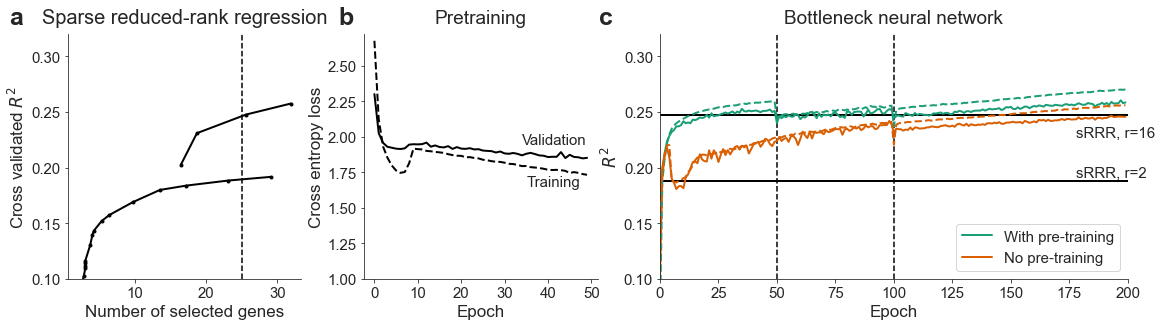

In [41]:
# All together in one plot
linewidth = 2
sns_styleset()

# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    cr_2 = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
    cr_16= np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]
    
    

# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    r_rank2_r = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_rank16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
    r_rank16_r = np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]

# All together in one plot for the paper
fig = plt.figure(figsize=(19, 4.5))
widths = [1, 1, 2]
heights = [1]
spec = fig.add_gridspec(ncols=3, nrows=1, width_ratios=widths,
                          height_ratios=heights)
ax1 = fig.add_subplot(spec[0, 0])
ax1.plot(n_2, cr_2, '.-', c = np.array([0, 0, 0])/256, linewidth=2)
ax1.plot(n_16[1:], cr_16[1:], '.-', c = np.array([0, 0, 0]) / 256, linewidth=2)
ax1.set_ylim([0.1,0.32])
ax1.set_xlabel('Number of selected genes', fontsize = 17)
ax1.set_ylabel(r'Cross validated $R^2$', fontsize = 17)
ax1.set_title('Sparse reduced-rank regression', fontsize = 20, y=1.02)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.tick_params(axis='both', which='minor', labelsize=15)
ax1.vlines(x=25, ymin=ax1.get_ylim()[0], ymax=ax1.get_ylim()[1], linestyles='dashed')
ax1.annotate('sRRR, r=16', (70, np.max(cr_16)+0.0003), fontsize=15)
ax1.annotate('sRRR, r=2', (55, np.max(cr_2)+0.0003), fontsize=15)


ax2 = fig.add_subplot(spec[0, 1])
ax2.plot(range(50), np.mean(pre_tr_hist_tr, axis=(0, 2))[2, :], \
         '--', c = 'k', linewidth=linewidth)
ax2.plot(range(50), np.mean(pre_tr_hist, axis=(0, 2))[2, :], \
         c = 'k', linewidth=linewidth)
ax2.set_title('Pretraining', fontsize = 19, y=1.02)
ax2.set_xlabel('Epoch', fontsize = 17)
ax2.set_ylabel('Cross entropy loss', fontsize = 17)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='minor', labelsize=15)
ax2.set_ylim([1, ax2.get_ylim()[1]])
ax2.annotate('Training', (35, 1.65), fontsize=15)
ax2.annotate('Validation', (34, 1.95), fontsize=15)
ax2.set_xticks(np.arange(0, 60, 10))

epochs_used=200
ax3 = fig.add_subplot(spec[0, 2])
ax3.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist_tr, axis=(0))[2,0,:], \
         '--', c = '#1b9e77', linewidth=linewidth)
ax3.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist, axis=(0))[2,0,:], \
         c = '#1b9e77', linewidth=linewidth, label='With pre-training')
# ax3.plot(range(epochs_used), np.mean(r2_pretr_straight_regr_hist_tr, axis=(0))[0,0,:], \
#          '--', c = '#d95f02', linewidth=linewidth)
# ax3.plot(range(epochs_used), np.mean(r2_pretr_straight_regr_hist, axis=(0))[0,0,:], \
#          c = '#d95f02', linewidth=linewidth, label='Pre-training + no freezing')
ax3.plot(range(epochs_used), np.mean(r2_straight_regr_hist_tr, axis=(0))[0,0,:], \
         '--', c = '#d95f02', linewidth=linewidth)
ax3.plot(range(epochs_used), np.mean(r2_straight_regr_hist, axis=(0))[0,0,:], \
         c = '#d95f02', linewidth=linewidth, label='No pre-training')
ax3.hlines(r_rank16_r[np.isclose(n_rank16, 25, atol=4)], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax3.hlines(r_rank2_r[np.isclose(n_rank2, 25, atol=2)], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax3.set_ylim([0.1,0.32])
ax3.set_xlim([0,200])
ax3.set_xticks(np.arange(0, 225, 25))
ax3.annotate('sRRR, r=16', (178, r_rank16_r[np.isclose(n_rank16, 25, atol=4)][0]-0.02), fontsize=15)
ax3.annotate('sRRR, r=2', (178, r_rank2_r[np.isclose(n_rank2, 25, atol=2)][0]+0.003), fontsize=15)
ax3.set_title('Bottleneck neural network', fontsize = 19, y=1.02)
ax3.set_xlabel('Epoch', fontsize = 17)
ax3.set_ylabel(r'$R^2$', fontsize = 17)
ax3.tick_params(axis='both', which='major', labelsize=15)
ax3.tick_params(axis='both', which='minor', labelsize=15)
ax3.legend(loc='lower right', fontsize=15)
ax3.vlines(x=50, ymin=ax3.get_ylim()[0], ymax=ax3.get_ylim()[1], linestyles='dashed')
ax3.vlines(x=100, ymin=ax3.get_ylim()[0], ymax=ax3.get_ylim()[1], linestyles='dashed')

plt.text(-0.25, 1.04, 'a', transform = ax1.transAxes, fontsize=25, fontweight='bold')
plt.text(-0.11, 1.04, 'b', transform = ax2.transAxes, fontsize=25, fontweight='bold')
plt.text(-0.13, 1.04, 'c', transform = ax3.transAxes, fontsize=25, fontweight='bold')
sns.despine()

# plt.savefig('figures/Allen_Lasso_training_curves.pdf', bbox_inches='tight',
#     pad_inches=0)
# plt.savefig('figures/Allen_Lasso_training_curves.png', bbox_inches='tight',
#     pad_inches=0)

# Different # layers frozen

In [108]:
from bottleneck_networks import FreezeUnfreeze

In [135]:
# Settings
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-1])

act = 'elu'
folds = 5
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs
pre_trained_weights=True
unfreeze = [False, True, True, True, True, True] # last 1 layer can be trained only first
prune=True

r2_before_unfreezing = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_before_unfreezing_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing_ap = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing_ap_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_freeze_unfreeze_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))
r2_freeze_unfreeze_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))

t = time.time()
np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]

nodes_list=[512,128,2,128,512]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    input_dim = x_train.shape[1]
    output_dim = y_train.shape[1]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)
            
            pre_trained_weights_h5 = 'KerasSavedModels/Classification_last_weights_{}_{}_{}.h5'.format(cvfold, 2, i)
            input_dim = x_train.shape[1]
            output_dim = y_train.shape[1]
            BN_PreTrFreezeUnfreeze = FreezeUnfreeze(l1=l1, l2=l2, lr=lr, act=act, input_dim=input_dim, output_dim=output_dim, \
                                                       unfreeze = unfreeze, \
                                                       pre_trained_weights=pre_trained_weights, \
                                                       pre_trained_weights_h5=pre_trained_weights_h5, nodes_list=nodes_list)
            r2_before_unfreezing_train, r2_before_unfreezing_test, \
                r2_after_unfreezing_train, r2_after_unfreezing_test, \
                r2_after_unfreezing_train_ap, r2_after_unfreezing_test_ap, \
                train_hist, test_hist = BN_PreTrFreezeUnfreeze.train(x_train=x_train, y_train=y_train, \
                                                                    x_test=x_test, y_test=y_test, \
                                                                    epochs=epochs, bs=bs, patience=patience, \
                                                                    cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                    prune=prune, geneNames=gene_names, \
                                                                    verbose=0)
            r2_before_unfreezing[cvfold, j, i] = r2_before_unfreezing_test
            r2_before_unfreezing_tr[cvfold, j, i] = r2_before_unfreezing_train
            r2_after_unfreezing[cvfold, j, i] = r2_after_unfreezing_test
            r2_after_unfreezing_tr[cvfold, j, i] = r2_after_unfreezing_train
            r2_after_unfreezing_ap[cvfold, j, i] = r2_after_unfreezing_test_ap
            r2_after_unfreezing_ap_tr[cvfold, j, i] = r2_after_unfreezing_train_ap
            r2_freeze_unfreeze_hist[cvfold, j, i] = test_hist
            r2_freeze_unfreeze_hist_tr[cvfold, j, i] = train_hist
            #print('Test R^2 score (before unfreezing): ', r2_before_unfreezing[cvfold, j, i])
            #print('Test R^2 score (after unfreezing): ', r2_after_unfreezing[cvfold, j, i])
            #print('Test R^2 score (after unfreezing and after pruning): ', r2_after_unfreezing_ap[cvfold, j, i])
            
t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0
[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Kcnab1' 'Cntn4' 'Unc5d' 'Ak5' 'Galnt18' 'Nell1' 'Ptprt' 'Cplx3' 'Syt6'
 'Brinp3' 'A830018L16Rik' 'Gabrb2' 'Cdh7' 'Ndst3' 'Pcp4l1' 'Cacna2d3'
 'Zfp804a' 'Lrp1b' 'Sorcs1' 'Pvalb' 'Fxyd6' 'Mybpc1' 'Lamp5' 'Synpr' 'Vip']
[INFO] training network...
Train R^2 before unfreezing:  0.26550036668777466
Test R^2 before unfreezing:  0.278472363948822
Train R^2 after unfreezing:  0.26888471841812134
Test R^2 after unfreezing:  0.27625423669815063
Train R^2 after unfreezing and pruning:  0.2773968577384949
Test R^2 after unfreezing and pruning:  0.281141459941864

CVFOLD:  1
[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Asic2' 'Alcam' 'Lrp1b' 'Npas3' 'Whrn' 'Lamp5' 'Tox' 'Tmem44' 'Srrm4'
 'Cntnap5c' 'Kcnab1' 'Sema3a' 'Zfp804a' 'Kctd8' 'Cacna1e' 'Nkain3' 'Ano4'
 'Npy' 'Pvalb' 'Nxph1' 'Zfp536' 'Mybpc1' 'Sst' 'Adarb2' 'Vip']
[INFO] training network...
Train R^2 before un

In [130]:
# with open('KerasSavedModels/gouwens_2020/Bottleneck_r2_pre_tr_and_freeze_butlastlayer_unfreeze_lasso.pickle', 'wb') as f:
#     pickle.dump([r2_before_unfreezing, r2_before_unfreezing_tr, \
#                  r2_after_unfreezing, r2_after_unfreezing_tr, \
#                  r2_after_unfreezing_ap, r2_after_unfreezing_ap_tr, \
#                  r2_freeze_unfreeze_hist, r2_freeze_unfreeze_hist_tr], f)

In [136]:
with open('KerasSavedModels/gouwens_2020/Bottleneck_r2_pre_tr_and_freeze_1stlayeronly_unfreeze_lasso.pickle', 'wb') as f:
    pickle.dump([r2_before_unfreezing, r2_before_unfreezing_tr, \
                 r2_after_unfreezing, r2_after_unfreezing_tr, \
                 r2_after_unfreezing_ap, r2_after_unfreezing_ap_tr, \
                 r2_freeze_unfreeze_hist, r2_freeze_unfreeze_hist_tr], f)

And loading all required files to plot

In [116]:
lambdas = np.arange(.5,3,.1)
alphas = np.array([1])

In [117]:
with open('KerasSavedModels/gouwens_2020/sRRR_vs_Bottleneck_rank2_CV_lasso.pickle', 'rb') as f:
    r2_sRRR_rank2, r2_sRRR_relaxed_rank2, r2_sRRR_rank2_tr, r2_sRRR_relaxed_rank2_tr, \
                nonzero_rank2, corrs_rank2, corrs_relaxed_rank2 = pickle.load(f)

In [118]:
with open('KerasSavedModels/gouwens_2020/sRRR_vs_Bottleneck_rank16_CV_lasso.pickle', 'rb') as f:
    r2_sRRR_rank16, r2_sRRR_relaxed_rank16, r2_sRRR_rank16_tr, r2_sRRR_relaxed_rank16_tr, \
                nonzero_rank16, corrs_rank16, corrs_relaxed_rank16 = pickle.load(f)

In [119]:
with open('KerasSavedModels/gouwens_2020/Bottleneck_pre_tr_lasso.pickle', 'rb') as f:
    CE_loss, CE_loss_tr, pre_tr_hist, pre_tr_hist_tr = pickle.load(f)

In [120]:
with open('KerasSavedModels/gouwens_2020/Bottleneck_r2_straight_regr_lasso.pickle', 'rb') as f:
    r2_straight_regr, r2_straight_regr_tr, \
    r2_straight_regr_ap, r2_straight_regr_ap_tr, \
    r2_straight_regr_hist, r2_straight_regr_hist_tr = pickle.load(f)

In [121]:
with open('KerasSavedModels/gouwens_2020/Bottleneck_r2_pre_tr_and_straight_regr_lasso.pickle', 'rb') as f:
    r2_pretr_straight_regr, r2_pretr_straight_regr_tr, \
    r2_pretr_straight_regr_ap, r2_pretr_straight_regr_ap_tr, \
    r2_pretr_straight_regr_hist, r2_pretr_straight_regr_hist_tr = pickle.load(f)

In [131]:
with open('KerasSavedModels/gouwens_2020/Bottleneck_r2_pre_tr_and_freeze_unfreeze_lasso.pickle', 'rb') as f:
    r2_before_unfreezing, r2_before_unfreezing_tr, \
    r2_after_unfreezing, r2_after_unfreezing_tr, \
    r2_after_unfreezing_ap, r2_after_unfreezing_ap_tr, \
    r2_freeze_unfreeze_hist, r2_freeze_unfreeze_hist_tr = pickle.load(f)

In [132]:
with open('KerasSavedModels/gouwens_2020/Bottleneck_r2_pre_tr_and_freeze_butlastlayer_unfreeze_lasso.pickle', 'rb') as f:
    r2_before_unfreezing_butlast, r2_before_unfreezing_tr_butlast, \
    r2_after_unfreezing_butlast, r2_after_unfreezing_tr_butlast, \
    r2_after_unfreezing_ap_butlast, r2_after_unfreezing_ap_tr_butlast, \
    r2_freeze_unfreeze_hist_butlast, r2_freeze_unfreeze_hist_tr_butlast = pickle.load(f)

In [137]:
with open('KerasSavedModels/gouwens_2020/Bottleneck_r2_pre_tr_and_freeze_1stlayeronly_unfreeze_lasso.pickle', 'rb') as f:
    r2_before_unfreezing_1stonly, r2_before_unfreezing_tr_1stonly, \
    r2_after_unfreezing_1stonly, r2_after_unfreezing_tr_1stonly, \
    r2_after_unfreezing_ap_1stonly, r2_after_unfreezing_ap_tr_1stonly, \
    r2_freeze_unfreeze_hist_1stonly, r2_freeze_unfreeze_hist_tr_1stonly = pickle.load(f)

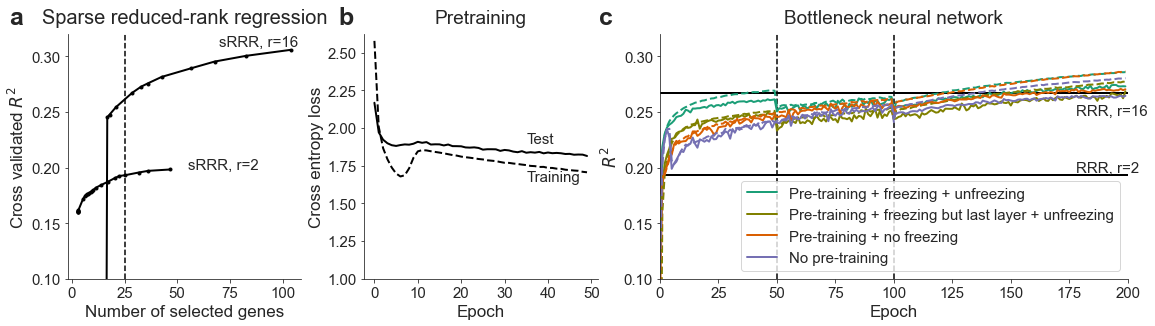

In [134]:
# All together in one plot
linewidth = 2
sns_styleset()

# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    cr_2 = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
    cr_16= np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]
    
    

# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    r_rank2_r = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_rank16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
    r_rank16_r = np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]

# All together in one plot for the paper
fig = plt.figure(figsize=(19, 4.5))
widths = [1, 1, 2]
heights = [1]
spec = fig.add_gridspec(ncols=3, nrows=1, width_ratios=widths,
                          height_ratios=heights)
ax1 = fig.add_subplot(spec[0, 0])
ax1.plot(n_2, cr_2, '.-', c = np.array([0, 0, 0])/256, linewidth=2)
ax1.plot(n_16[1:], cr_16[1:], '.-', c = np.array([0, 0, 0]) / 256, linewidth=2)
ax1.set_ylim([0.1,0.32])
ax1.set_xlabel('Number of selected genes', fontsize = 17)
ax1.set_ylabel(r'Cross validated $R^2$', fontsize = 17)
ax1.set_title('Sparse reduced-rank regression', fontsize = 20, y=1.02)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.tick_params(axis='both', which='minor', labelsize=15)
ax1.vlines(x=25, ymin=ax1.get_ylim()[0], ymax=ax1.get_ylim()[1], linestyles='dashed')
ax1.annotate('sRRR, r=16', (70, np.max(cr_16)+0.0003), fontsize=15)
ax1.annotate('sRRR, r=2', (55, np.max(cr_2)+0.0003), fontsize=15)


ax2 = fig.add_subplot(spec[0, 1])
ax2.plot(range(50), np.mean(pre_tr_hist_tr, axis=(0, 2))[2, :], \
         '--', c = 'k', linewidth=linewidth)
ax2.plot(range(50), np.mean(pre_tr_hist, axis=(0, 2))[2, :], \
         c = 'k', linewidth=linewidth)
ax2.set_title('Pretraining', fontsize = 19, y=1.02)
ax2.set_xlabel('Epoch', fontsize = 17)
ax2.set_ylabel('Cross entropy loss', fontsize = 17)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='minor', labelsize=15)
ax2.set_ylim([1, ax2.get_ylim()[1]])
ax2.annotate('Training', (35, 1.65), fontsize=15)
ax2.annotate('Test', (35, 1.9), fontsize=15)
ax2.set_xticks(np.arange(0, 60, 10))

epochs_used=200
ax3 = fig.add_subplot(spec[0, 2])
ax3.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist_tr, axis=(0))[2,1,:], \
         '--', c = '#1b9e77', linewidth=linewidth)
ax3.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist, axis=(0))[2,1,:], \
         c = '#1b9e77', linewidth=linewidth, label='Pre-training + freezing + unfreezing')
ax3.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist_tr_butlast, axis=(0))[0,0,:], \
         '--', c = 'olive', linewidth=linewidth)
ax3.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist_butlast, axis=(0))[0,0,:], \
         c = 'olive', linewidth=linewidth, label='Pre-training + freezing but last layer + unfreezing')
ax3.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist_tr_butlast, axis=(0))[0,0,:], \
         '--', c = 'black', linewidth=linewidth)
ax3.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist_butlast, axis=(0))[0,0,:], \
         c = 'black', linewidth=linewidth, label='Pre-training + freezing 1st layer only + unfreezing')
ax3.plot(range(epochs_used), np.mean(r2_pretr_straight_regr_hist_tr, axis=(0))[0,1,:], \
         '--', c = '#d95f02', linewidth=linewidth)
ax3.plot(range(epochs_used), np.mean(r2_pretr_straight_regr_hist, axis=(0))[0,1,:], \
         c = '#d95f02', linewidth=linewidth, label='Pre-training + no freezing')
ax3.plot(range(epochs_used), np.mean(r2_straight_regr_hist_tr, axis=(0))[0,1,:], \
         '--', c = '#7570b3', linewidth=linewidth)
ax3.plot(range(epochs_used), np.mean(r2_straight_regr_hist, axis=(0))[0,1,:], \
         c = '#7570b3', linewidth=linewidth, label='No pre-training')
ax3.hlines(r_rank16_r[np.isclose(n_rank16, 25, atol=4)], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax3.hlines(r_rank2_r[np.isclose(n_rank2, 25, atol=2)], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax3.set_ylim([0.1,0.32])
ax3.set_xlim([0,200])
ax3.set_xticks(np.arange(0, 225, 25))
ax3.annotate('RRR, r=16', (178, r_rank16_r[np.isclose(n_rank16, 25, atol=4)][0]-0.02), fontsize=15)
ax3.annotate('RRR, r=2', (178, r_rank2_r[np.isclose(n_rank2, 25, atol=2)][0]+0.003), fontsize=15)
ax3.set_title('Bottleneck neural network', fontsize = 19, y=1.02)
ax3.set_xlabel('Epoch', fontsize = 17)
ax3.set_ylabel(r'$R^2$', fontsize = 17)
ax3.tick_params(axis='both', which='major', labelsize=15)
ax3.tick_params(axis='both', which='minor', labelsize=15)
ax3.legend(loc='lower right', fontsize=13)
ax3.vlines(x=50, ymin=ax3.get_ylim()[0], ymax=ax3.get_ylim()[1], linestyles='dashed')
ax3.vlines(x=100, ymin=ax3.get_ylim()[0], ymax=ax3.get_ylim()[1], linestyles='dashed')

plt.text(-0.25, 1.04, 'a', transform = ax1.transAxes, fontsize=25, fontweight='bold')
plt.text(-0.11, 1.04, 'b', transform = ax2.transAxes, fontsize=25, fontweight='bold')
plt.text(-0.13, 1.04, 'c', transform = ax3.transAxes, fontsize=25, fontweight='bold')
sns.despine()

plt.savefig('figures/Allen_Lasso_training_curves_plusfreezebutlastlayer.pdf', bbox_inches='tight',
    pad_inches=0)
plt.savefig('figures/Allen_Lasso_training_curves_plusfreezebutlastlayer.png', bbox_inches='tight',
    pad_inches=0)